# Introduction

This project is going to look for EEG biomarkers of alcoholism. The main goal of this project is try and predict whether a person is an alcholic or not based on features obtained from the EEG data we have. 

The EEG Database on UCI website contains 64-channel electroencephalography (EEG) data from 121 alcoholic and control subjects participating in a visual event-related potential (ERP) experiment.

Subjects were exposed to three experimental conditions:

(1)obj single visual stimulus
(2)match two matching visual stimuli
(3)nonmatch two non-matching visual stimuli.

Each subject participated in multiple trials (replications) of each experimental condition. Data were recorded at 256 Hz for 1 second following the presentation of the visual stimulus/stimuli.


The main goal of this project is try and predict whether a person is an alcholic based on various features obtained from the EEG data we have. 



## Read in Data

The data has already been pre-processed. You can get all the raw files here: https://drive.google.com/drive/folders/1QEsxcAWYLakE35Dt2I4dcxgTatYMuG_D?usp=sharing. Below you will find the script to read in the 121 data files and combine them all together from the `eeg_folder` folder on your computer. 


In [2]:
import os             # File management
import pandas as pd     # Data frame manipulation
import numpy as np      # Data frame operations
import glob
import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting
import dask as dd # read in 
from dask import dataframe as dd
import vaex


## import our classifiers
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## The VotingClassifier
from sklearn.ensemble import VotingClassifier

## import accuracy metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## split data
from sklearn.model_selection import train_test_split

## validation and model selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



In [17]:
def print_grid_search_metrics(gs):
  # gs: grid search result.
  print('Best score:', gs.best_score_)
  print('Best parameters set:')
  best_parameters = gs.best_params_
  for param_name in sorted(best_parameters.keys()):
    print(param_name + ':'+str(best_parameters[param_name]))

In [7]:

path= '/Users/jgeller1/Desktop/ERDOS_EEG_Project3/egg_data' # this will be different and needs to be changed on own computer

all_files = glob.glob(os.path.join(path, "*.csv")) # join path and append .csv to end

all_files

len(all_files)

121

# Concatenate 

Here we are going to concatenate all the csv files together. In order to speed up reading all these files in we are going to use the `vaex` package. It is incredibly efficent for reading in all the files. 

In [8]:
%%time
df_concat = vaex.open_many(all_files)

#concat_df=(pd.concat(pd.read_csv(f) for f in all_files))




CPU times: user 2min 15s, sys: 15.8 s, total: 2min 31s
Wall time: 2min 32s


With `vaex` it takes us 2min and 15s to process all the files. With another method it could take 10-15 minutes. 

In [9]:
df_concat.head()

#,Unnamed: 0,Unnamed: 0.1,subject,trial,alcoholic,match,err,sensor,sample,value
0,0,0,'co3c0000402',2,False,'obj',False,'FP1',0,0.732
1,1,1,'co3c0000402',2,False,'obj',False,'FP1',1,2.686
2,2,2,'co3c0000402',2,False,'obj',False,'FP1',2,5.127
3,3,3,'co3c0000402',2,False,'obj',False,'FP1',3,7.568
4,4,4,'co3c0000402',2,False,'obj',False,'FP1',4,9.033
5,5,5,'co3c0000402',2,False,'obj',False,'FP1',5,9.521
6,6,6,'co3c0000402',2,False,'obj',False,'FP1',6,9.521
7,7,7,'co3c0000402',2,False,'obj',False,'FP1',7,9.033
8,8,8,'co3c0000402',2,False,'obj',False,'FP1',8,9.033
9,9,9,'co3c0000402',2,False,'obj',False,'FP1',9,9.521


The df_concat object has several columns: 

    - subject: Subject number
    - trail: Trial number
    - alcholic: True (alcholic) False not
    - match: Condition (match, nonmatch, obj)
    - err: 
    - sensor: senor locations (one of 64)
    - sample: Time
    - value : Voltage (uV)
    

Due to computational issues, we subset our data to only look at one electrode(Cz) and then we will aggregate across time and trials. 


In [10]:
df_Cz = df_concat[df_concat.sensor.isin(["CZ"])] # select Cz channel 

In [27]:
df_Cz.export_csv('no_cz_trials.csv') # let's save this as a csv

In [29]:
cz_df=pd.read_csv('no_cz_trials.csv')

cz_df

,Unnamed: 0,Unnamed: 0.1,subject,trial,alcoholic,match,err,sensor,sample,value
0,3840,3840.0,co3c0000402,2,False,obj,False,CZ,0,8.219
1,3841,3841.0,co3c0000402,2,False,obj,False,CZ,1,8.219
2,3842,3842.0,co3c0000402,2,False,obj,False,CZ,2,7.731
3,3843,3843.0,co3c0000402,2,False,obj,False,CZ,3,7.243
4,3844,3844.0,co3c0000402,2,False,obj,False,CZ,4,7.243
...,...,...,...,...,...,...,...,...,...,...
2804219,1576955,NaN,co2a0000403,119,True,match,False,CZ,251,-28.168
2804220,1576956,NaN,co2a0000403,119,True,match,False,CZ,252,-28.168
2804221,1576957,NaN,co2a0000403,119,True,match,False,CZ,253,-29.633
2804222,1576958,NaN,co2a0000403,119,True,match,False,CZ,254,-32.562


Let's look at the amplitude differences between alcholics and controls across each of three conditions

Let's change the sampling rate so it is in milliseconds and not some abritrary number. 

In [102]:
cz_df["sample"] = pd.to_numeric(cz_df["sample"], downcast="float")

cz_df['Time'] = cz_df[['sample']]*3.91 # change to ms

cz_df['subject'] = cz_df['subject'].astype(str)

cz_df['match'] = cz_df['match'].astype(str)


cz_df

,Unnamed: 0,Unnamed: 0.1,subject,trial,alcoholic,match,err,sensor,sample,value,Time
0,3840,3840.0,co3c0000402,2,False,obj,False,CZ,0.0,8.219,0.000000
1,3841,3841.0,co3c0000402,2,False,obj,False,CZ,1.0,8.219,3.910000
2,3842,3842.0,co3c0000402,2,False,obj,False,CZ,2.0,7.731,7.820000
3,3843,3843.0,co3c0000402,2,False,obj,False,CZ,3.0,7.243,11.730000
4,3844,3844.0,co3c0000402,2,False,obj,False,CZ,4.0,7.243,15.640000
...,...,...,...,...,...,...,...,...,...,...,...
2804219,1576955,NaN,co2a0000403,119,True,match,False,CZ,251.0,-28.168,981.410034
2804220,1576956,NaN,co2a0000403,119,True,match,False,CZ,252.0,-28.168,985.320007
2804221,1576957,NaN,co2a0000403,119,True,match,False,CZ,253.0,-29.633,989.230042
2804222,1576958,NaN,co2a0000403,119,True,match,False,CZ,254.0,-32.562,993.140015


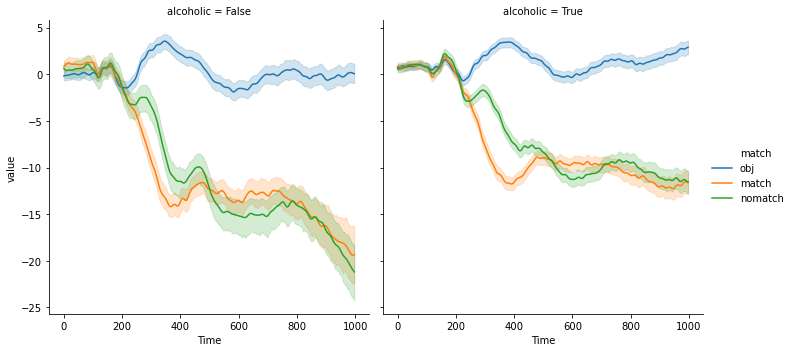

In [110]:

ax=sns.relplot(x="Time", y="value", kind="line", hue="match", col="alcoholic", data=cz_df)


plt.show()


In [ ]:
Let's look at the amplitude differences between alcholics and controls aggregated across condition and retun some 

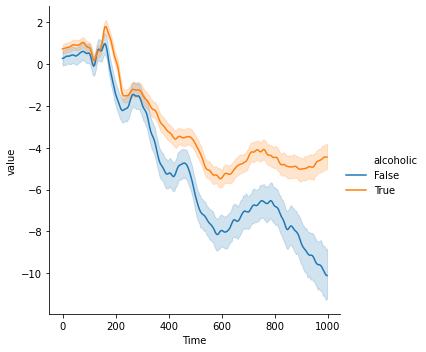

In [85]:
ax=sns.relplot(x="Time", y="value", kind="line", hue="alcoholic", data=cz_df)


plt.show()

Now that our data is a bit smaller let's use pandas to work with the data. 

# Features

There are a number of features one could look at with this type of data. Here I am going to extract a few features I think our important.




## Mean amplitude for each condition by subject

To do this we will group by subject, match, sample, and alcholic category. We will create a wide DF to add to a bigger feature csv file. 

In [117]:

df1_agg = cz_df.groupby(['subject', 'match', 'alcoholic'])['value'].mean()


df1_agg.head()

subject      match    alcoholic
co2a0000364  match    True        -15.778111
             nomatch  True        -14.104428
             obj      True          5.108323
co2a0000365  match    True         -8.428477
             nomatch  True         -8.517720
Name: value, dtype: float64

In [118]:
df1_agg.to_csv('no_trials.csv') # let's save this as a csv

In [119]:
no_trials=pd.read_csv('no_trials.csv')

no_trials

,subject,match,alcoholic,value
0,co2a0000364,match,True,-15.778111
1,co2a0000364,nomatch,True,-14.104428
2,co2a0000364,obj,True,5.108323
3,co2a0000365,match,True,-8.428477
4,co2a0000365,nomatch,True,-8.517720
...,...,...,...,...
358,co3a0000461,nomatch,True,-3.504227
359,co3a0000461,obj,True,-0.739263
360,co3c0000402,match,False,-13.558304
361,co3c0000402,nomatch,False,-12.589800


## P300


A classic neurophysiological marker is the P300 which is a positive amplitude beween 250 ms and 550 ms. Lets get the mean amplitude between those times for each subject to use as features in our random forest design. 

In [124]:

df_p300= cz_df[(cz_df['Time'] >= 250) & (cz_df['Time'] <=550)] # get mean P300 


df_p300_df=df_p300.groupby(["subject", "alcoholic", "match"]).value.mean()

# write file to csv
df_p300_df

df_p300_df.to_csv("df_p300", sep='\t', encoding='utf-8')

#groupby('subject').value.mean()

In [126]:
df_p300_df=df_p300.groupby(["subject", "alcoholic", "match"]).value.mean() # take the mean 

In [128]:
df_p300_df

subject      alcoholic  match  
co2a0000364  True       match     -14.191272
                        nomatch    -9.451732
                        obj         9.249465
co2a0000365  True       match     -10.046991
                        nomatch    -6.466113
                                     ...    
co3a0000461  True       nomatch    -2.253674
                        obj         3.265270
co3c0000402  False      match     -14.373963
                        nomatch   -12.694069
                        obj         2.948908
Name: value, Length: 363, dtype: float64

In [ ]:
df_p300_df.to_csv('p300_trials.csv') #  save this as a csv

In [137]:
P300_means = pd.read_csv("p300_trials.csv") # read in csv



In [138]:
P300_means.rename(index=str, columns={"value": "P300"}) #rename column


,subject,alcoholic,match,P300
0,co2a0000364,True,match,-14.191272
1,co2a0000364,True,nomatch,-9.451732
2,co2a0000364,True,obj,9.249465
3,co2a0000365,True,match,-10.046991
4,co2a0000365,True,nomatch,-6.466113
...,...,...,...,...
358,co3a0000461,True,nomatch,-2.253674
359,co3a0000461,True,obj,3.265270
360,co3c0000402,False,match,-14.373963
361,co3c0000402,False,nomatch,-12.694069


In [139]:
P300_means.to_csv('p300_means_cond.csv') #  save this as a csv

In [154]:
merge_df=P300_means.merge(no_trials, how='left', on=['subject', 'alcoholic', 'match']) # merge the two dfs

merge_df

,subject,alcoholic,match,value_x,value_y
0,co2a0000364,True,match,-14.191272,-15.778111
1,co2a0000364,True,nomatch,-9.451732,-14.104428
2,co2a0000364,True,obj,9.249465,5.108323
3,co2a0000365,True,match,-10.046991,-8.428477
4,co2a0000365,True,nomatch,-6.466113,-8.517720
...,...,...,...,...,...
358,co3a0000461,True,nomatch,-2.253674,-3.504227
359,co3a0000461,True,obj,3.265270,-0.739263
360,co3c0000402,False,match,-14.373963,-13.558304
361,co3c0000402,False,nomatch,-12.694069,-12.589800


Here is an overview of the other features we looked at for this project: 

- P300 mean for each condition: average signal between 250 ms and 550 ms for channel Cz in the single object condition (Jason) 
- Mean for each condition: average signal for channel Cz in each condition (Jason) 
- Correlation between sensors for each condition (Derek)
- Mean “response” frequency of the Cz channel (Jared)
- Mean band frequency for CZ channel for each condition (Serena) 




In [145]:
merge_df.to_csv('merge_P300_cond_means.csv') #  save this as a csv

# Feature Selection

Now that we have our features let's see how good our features our in predicting whether someone is an alhcolic or not.
For this part we are going to download the dataset from our team's Github page. 





In [18]:
url='https://raw.githubusercontent.com/jgeller112/ERDOS_EEG_Project/main/Feature_Folder/jason_derek_josimar_serena_jared_comb.csv'
df_full = pd.read_csv(url, error_bad_lines=False)

df_full = df_full.drop(columns=['Unnamed: 0'])
df_full

,subject,mean_freq,alcoholic,CP5_F2_match,CP5_F2_nomatch,CP5_F2_obj,CP2_FT8_match,CP2_FT8_nomatch,CP2_FT8_obj,P3_PO2_match,...,Beta_obj,Delta_match,Delta_nomatch,Delta_obj,Gamma_match,Gamma_nomatch,Gamma_obj,Theta_match,Theta_nomatch,Theta_obj
0,co2a0000364,3.154577,True,0.200030,0.211414,0.550771,-0.435512,-0.536246,-0.404910,-0.130693,...,994.688299,6533.895744,5814.133556,7709.801208,654.692196,569.614062,951.710876,2003.244436,1600.974238,2199.673799
1,co2a0000365,3.373054,True,0.521817,0.272875,0.457085,-0.626006,-0.469507,-0.584003,0.689151,...,1002.695790,5796.393521,4720.341694,6831.595791,352.494087,303.540503,481.708125,2001.376195,1710.349151,2478.941497
2,co2a0000368,2.395196,True,0.281701,0.562318,0.126599,-0.527075,-0.493691,-0.538776,0.813730,...,655.784305,4301.165082,5373.522022,5494.225301,281.277853,371.741663,486.707889,916.292236,1487.448512,1671.991425
3,co2a0000369,2.635432,True,0.857280,0.706349,0.707260,-0.848527,-0.712812,-0.759786,0.619967,...,1060.396595,6715.774289,4793.176483,10814.553600,405.321146,353.058808,582.735354,2484.474124,2592.628901,4272.324514
4,co2a0000370,4.058423,True,0.719606,0.812764,-0.049233,-0.472912,-0.489829,-0.607273,0.632839,...,848.511123,3845.290468,3808.705298,5171.851411,315.782526,331.540139,465.690690,1390.594143,1399.789222,1915.670651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,co3a0000458,2.513502,True,0.831934,0.862534,0.882192,-0.436328,-0.439382,-0.621502,0.657140,...,1309.189951,7883.138321,5435.174186,10041.670010,535.996123,508.046313,642.253467,1872.461606,1567.796587,2476.046689
116,co3a0000459,3.419872,True,0.378329,0.804246,0.700227,-0.559479,-0.527493,-0.505584,0.567803,...,1132.059951,5108.504718,5474.216759,4996.770001,500.577876,526.779410,735.398408,1065.843447,1412.891855,1769.545430
117,co3a0000460,2.761310,True,0.712670,0.742294,0.039392,-0.516215,-0.560386,-0.628500,0.693920,...,919.490201,5578.264995,4468.169967,6626.495691,305.383068,282.670063,514.464704,1926.545066,1592.055456,2195.459813
118,co3a0000461,3.090559,True,0.807962,0.869426,0.793601,-0.388024,-0.703584,-0.428644,0.741113,...,519.584060,4610.638916,4919.871324,5363.293366,531.344737,469.099193,383.896034,1211.517793,1513.406175,1275.089375


In [19]:

df_copy = df_full.copy()
df_copy

,subject,mean_freq,alcoholic,CP5_F2_match,CP5_F2_nomatch,CP5_F2_obj,CP2_FT8_match,CP2_FT8_nomatch,CP2_FT8_obj,P3_PO2_match,...,Beta_obj,Delta_match,Delta_nomatch,Delta_obj,Gamma_match,Gamma_nomatch,Gamma_obj,Theta_match,Theta_nomatch,Theta_obj
0,co2a0000364,3.154577,True,0.200030,0.211414,0.550771,-0.435512,-0.536246,-0.404910,-0.130693,...,994.688299,6533.895744,5814.133556,7709.801208,654.692196,569.614062,951.710876,2003.244436,1600.974238,2199.673799
1,co2a0000365,3.373054,True,0.521817,0.272875,0.457085,-0.626006,-0.469507,-0.584003,0.689151,...,1002.695790,5796.393521,4720.341694,6831.595791,352.494087,303.540503,481.708125,2001.376195,1710.349151,2478.941497
2,co2a0000368,2.395196,True,0.281701,0.562318,0.126599,-0.527075,-0.493691,-0.538776,0.813730,...,655.784305,4301.165082,5373.522022,5494.225301,281.277853,371.741663,486.707889,916.292236,1487.448512,1671.991425
3,co2a0000369,2.635432,True,0.857280,0.706349,0.707260,-0.848527,-0.712812,-0.759786,0.619967,...,1060.396595,6715.774289,4793.176483,10814.553600,405.321146,353.058808,582.735354,2484.474124,2592.628901,4272.324514
4,co2a0000370,4.058423,True,0.719606,0.812764,-0.049233,-0.472912,-0.489829,-0.607273,0.632839,...,848.511123,3845.290468,3808.705298,5171.851411,315.782526,331.540139,465.690690,1390.594143,1399.789222,1915.670651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,co3a0000458,2.513502,True,0.831934,0.862534,0.882192,-0.436328,-0.439382,-0.621502,0.657140,...,1309.189951,7883.138321,5435.174186,10041.670010,535.996123,508.046313,642.253467,1872.461606,1567.796587,2476.046689
116,co3a0000459,3.419872,True,0.378329,0.804246,0.700227,-0.559479,-0.527493,-0.505584,0.567803,...,1132.059951,5108.504718,5474.216759,4996.770001,500.577876,526.779410,735.398408,1065.843447,1412.891855,1769.545430
117,co3a0000460,2.761310,True,0.712670,0.742294,0.039392,-0.516215,-0.560386,-0.628500,0.693920,...,919.490201,5578.264995,4468.169967,6626.495691,305.383068,282.670063,514.464704,1926.545066,1592.055456,2195.459813
118,co3a0000461,3.090559,True,0.807962,0.869426,0.793601,-0.388024,-0.703584,-0.428644,0.741113,...,519.584060,4610.638916,4919.871324,5363.293366,531.344737,469.099193,383.896034,1211.517793,1513.406175,1275.089375


In [20]:
y = df_copy.alcoholic
X = df_copy.drop('alcoholic', axis = 1)

y

0       True
1       True
2       True
3       True
4       True
       ...  
115     True
116     True
117     True
118     True
119    False
Name: alcoholic, Length: 120, dtype: bool

In [21]:

X = X.drop('subject', axis = 1)
# If there is a categoric data
X = pd.get_dummies(X)
X

,mean_freq,CP5_F2_match,CP5_F2_nomatch,CP5_F2_obj,CP2_FT8_match,CP2_FT8_nomatch,CP2_FT8_obj,P3_PO2_match,P3_PO2_nomatch,P3_PO2_obj,...,Beta_obj,Delta_match,Delta_nomatch,Delta_obj,Gamma_match,Gamma_nomatch,Gamma_obj,Theta_match,Theta_nomatch,Theta_obj
0,3.154577,0.200030,0.211414,0.550771,-0.435512,-0.536246,-0.404910,-0.130693,0.029983,0.391106,...,994.688299,6533.895744,5814.133556,7709.801208,654.692196,569.614062,951.710876,2003.244436,1600.974238,2199.673799
1,3.373054,0.521817,0.272875,0.457085,-0.626006,-0.469507,-0.584003,0.689151,0.749709,0.601833,...,1002.695790,5796.393521,4720.341694,6831.595791,352.494087,303.540503,481.708125,2001.376195,1710.349151,2478.941497
2,2.395196,0.281701,0.562318,0.126599,-0.527075,-0.493691,-0.538776,0.813730,0.736933,0.870077,...,655.784305,4301.165082,5373.522022,5494.225301,281.277853,371.741663,486.707889,916.292236,1487.448512,1671.991425
3,2.635432,0.857280,0.706349,0.707260,-0.848527,-0.712812,-0.759786,0.619967,0.652720,0.804274,...,1060.396595,6715.774289,4793.176483,10814.553600,405.321146,353.058808,582.735354,2484.474124,2592.628901,4272.324514
4,4.058423,0.719606,0.812764,-0.049233,-0.472912,-0.489829,-0.607273,0.632839,0.222899,0.658522,...,848.511123,3845.290468,3808.705298,5171.851411,315.782526,331.540139,465.690690,1390.594143,1399.789222,1915.670651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2.513502,0.831934,0.862534,0.882192,-0.436328,-0.439382,-0.621502,0.657140,0.559631,-0.012934,...,1309.189951,7883.138321,5435.174186,10041.670010,535.996123,508.046313,642.253467,1872.461606,1567.796587,2476.046689
116,3.419872,0.378329,0.804246,0.700227,-0.559479,-0.527493,-0.505584,0.567803,0.403701,-0.192809,...,1132.059951,5108.504718,5474.216759,4996.770001,500.577876,526.779410,735.398408,1065.843447,1412.891855,1769.545430
117,2.761310,0.712670,0.742294,0.039392,-0.516215,-0.560386,-0.628500,0.693920,0.750775,0.757185,...,919.490201,5578.264995,4468.169967,6626.495691,305.383068,282.670063,514.464704,1926.545066,1592.055456,2195.459813
118,3.090559,0.807962,0.869426,0.793601,-0.388024,-0.703584,-0.428644,0.741113,0.767996,0.350732,...,519.584060,4610.638916,4919.871324,5363.293366,531.344737,469.099193,383.896034,1211.517793,1513.406175,1275.089375


Here we are going to split our data into training and test data. 


In [22]:

# GET TRAIN AND TEST DATA
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                    test_size = .2,
                                                    shuffle = True,
                                                    random_state=440,
                                                    stratify=y)

In [23]:

rf = RandomForestClassifier(random_state=440)
lr = LogisticRegression(max_iter=100000)
svc = SVC(kernel= 'rbf')
clf_vote = VotingClassifier([('lr', lr),('rf', rf),('svm',svc)])

In [24]:
# GET KFOLD VALIDATION
kfold = 5
models = [rf, lr, svc, clf_vote]

cv_results = []
for model in models:
  cv_results.append(cross_validate(model, X_train, y_train, cv=kfold))

In [25]:

cv_results_avg = np.zeros(len(cv_results))
for i in range(len(cv_results)):
  cv_results_avg[i] = np.mean(cv_results[i]['test_score'])

cv_results_avg



array([0.77157895, 0.76      , 0.62526316, 0.75052632])

# Logistic Regression

To reduce the number of features our model has we are going to run lasso logistic regression. 

In [26]:
lr_l1 = LogisticRegression(max_iter=100000, penalty = 'l1', solver = 'saga')
lr_l1.fit(X_train, y_train)


LogisticRegression(max_iter=100000, penalty='l1', solver='saga')

Here are beta coefficents 

In [39]:

lr_l1.coef_[0]

array([ 6.64873630e-05,  1.79102598e-05,  2.44499926e-05,  8.75049256e-05,
        3.25567277e-07,  1.19695265e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.73733455e-05,
        4.17013699e-07,  0.00000000e+00,  0.00000000e+00, -6.55520502e-06,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.21358287e-05,
       -3.89852767e-05,  0.00000000e+00,  1.84447558e-05,  0.00000000e+00,
        1.13799929e-05,  0.00000000e+00,  4.66270110e-07,  0.00000000e+00,
        2.68223021e-05,  4.02206360e-05,  4.86158335e-05, -3.18901135e-06,
        0.00000000e+00,  0.00000000e+00,  2.92194923e-06,  0.00000000e+00,
        1.77895446e-05,  1.39956494e-05,  0.00000000e+00,  1.95006193e-05,
        5.96371007e-05,  3.94850130e-05,  6.00679582e-05,  5.38904401e-05,
        2.13249814e-06,  3.48944957e-05,  4.80971809e-05,  5.86043719e-05,
        3.71087252e-05,  1.10031625e-04,  1.09615854e-04,  7.77412972e-05,
        1.80219989e-04, -

Let's drop all those unimportant features. 

In [40]:
X_train.columns[lr_l1.coef_[0] != 0]


Index(['mean_freq', 'CP5_F2_match', 'CP5_F2_nomatch', 'CP5_F2_obj',
       'CP2_FT8_match', 'CP2_FT8_nomatch', 'P4_FT8_nomatch', 'P4_FT8_obj',
       'AF7_FT8_obj', 'F5_FC4_match',
       ...
       'Beta_obj', 'Delta_match', 'Delta_nomatch', 'Delta_obj', 'Gamma_match',
       'Gamma_nomatch', 'Gamma_obj', 'Theta_match', 'Theta_nomatch',
       'Theta_obj'],
      dtype='object', length=244)

# Random Forest

Now we are going to tune our paramaters for our Random Forest

In [30]:
parameters = {'n_estimators':[50, 100, 200, 500], 
              'criterion':('gini','entropy'), 
              'min_samples_split':[2,4,6,8], 
              'max_features':('auto','log2'), 
              'max_depth':[5,10,20,100, 200]
              }
clf_gridCV = GridSearchCV(rf, parameters, cv = kfold)
clf_gridCV.fit(X_train, y_train)
sorted(clf_gridCV.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [41]:
# For selected features
rf_best_selected = clf_gridCV.best_estimator_
print_grid_search_metrics(clf_gridCV)

Best score: 0.8026315789473685
Best parameters set:
criterion:gini
max_depth:10
max_features:auto
min_samples_split:6
n_estimators:50


In [43]:
selected_columns=X_train.columns

selected_columns

Index(['mean_freq', 'CP5_F2_match', 'CP5_F2_nomatch', 'CP5_F2_obj',
       'CP2_FT8_match', 'CP2_FT8_nomatch', 'CP2_FT8_obj', 'P3_PO2_match',
       'P3_PO2_nomatch', 'P3_PO2_obj',
       ...
       'Beta_obj', 'Delta_match', 'Delta_nomatch', 'Delta_obj', 'Gamma_match',
       'Gamma_nomatch', 'Gamma_obj', 'Theta_match', 'Theta_nomatch',
       'Theta_obj'],
      dtype='object', length=265)

In [45]:
rf_best_selected.fit(X_train, y_train)

y_pred = rf_best_selected.predict(X_test[selected_columns])




In [47]:

df_importance_features = pd.DataFrame(rf_best_selected.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
df_importance_features.head(50)

,importance
40_S2nomatch,0.035322
C3_P8_nomatch,0.032659
50_S1obj,0.025263
54_S1obj,0.022932
42_S2nomatch,0.020716
48_S1obj,0.020451
47_S1obj,0.020303
14_S1obj,0.020055
51_S2nomatch,0.018629
50_S2nomatch,0.018275


Here are the top 20 important features for classifying alcoholics vs. non-alcholics. 

# Confusion Matrix 

In [48]:
# calculate accuracy, precision and recall, [[tn,fp],[]]
def cal_evaluation(classifier, cm):
  tn = cm[0][0]
  fp = cm[0][1]
  fn = cm[1][0]
  tp = cm[1][1]
  accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
  precision = tp / (tp + fp + 0.0)
  recall = tp / (tp + fn + 0.0)
  print(classifier)
  print("Accuracy is: " + str(accuracy))
  print("precision is: " + str(precision))
  print("recall is: " + str(recall))
  print('Specificity is', tn/(fp+tn))
  

# Pring out confusion matrix
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not Alcoholic','Alcoholic']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for ' + classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.75
precision is: 0.8
recall is: 0.8
Specificity is 0.6666666666666666


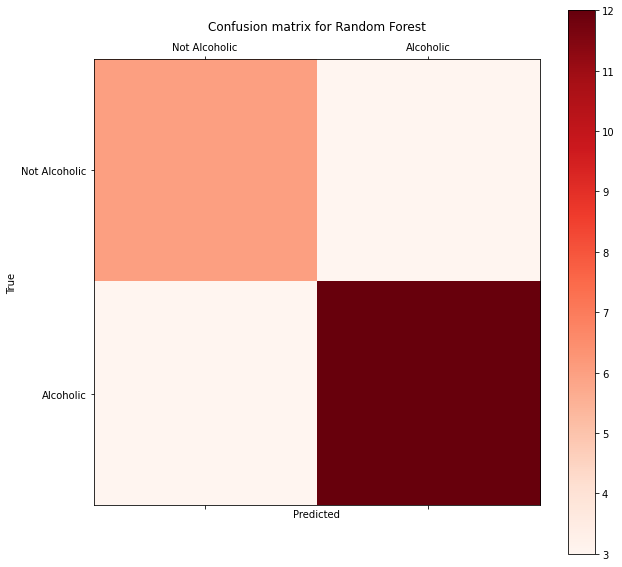

In [49]:
confusion_matrices = [("Random Forest", confusion_matrix(y_test,y_pred))]
draw_confusion_matrices(confusion_matrices)

# Conclusion


Our model does an okay job at classifying alcholoics from non-alcholoics. 
